Available sheets: ['Description', 'data']

✅ Loaded sheet: 'data'
Initial shape: (3999, 12)
Columns: ['ID#', 'Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles', 'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 'Flight_trans_12', 'Days_since_enroll', 'Award?']
Shape after cleaning: (3999, 11)

--- EDA: Basic Statistics ---
            Balance    Qual_miles    cc1_miles    cc2_miles    cc3_miles  \
count  3.999000e+03   3999.000000  3999.000000  3999.000000  3999.000000   
mean   7.360133e+04    144.114529     2.059515     1.014504     1.012253   
std    1.007757e+05    773.663804     1.376919     0.147650     0.195241   
min    0.000000e+00      0.000000     1.000000     1.000000     1.000000   
25%    1.852750e+04      0.000000     1.000000     1.000000     1.000000   
50%    4.309700e+04      0.000000     1.000000     1.000000     1.000000   
75%    9.240400e+04      0.000000     3.000000     1.000000     1.000000   
max    1.704838e+06  11148.000000     5.000000     3.0

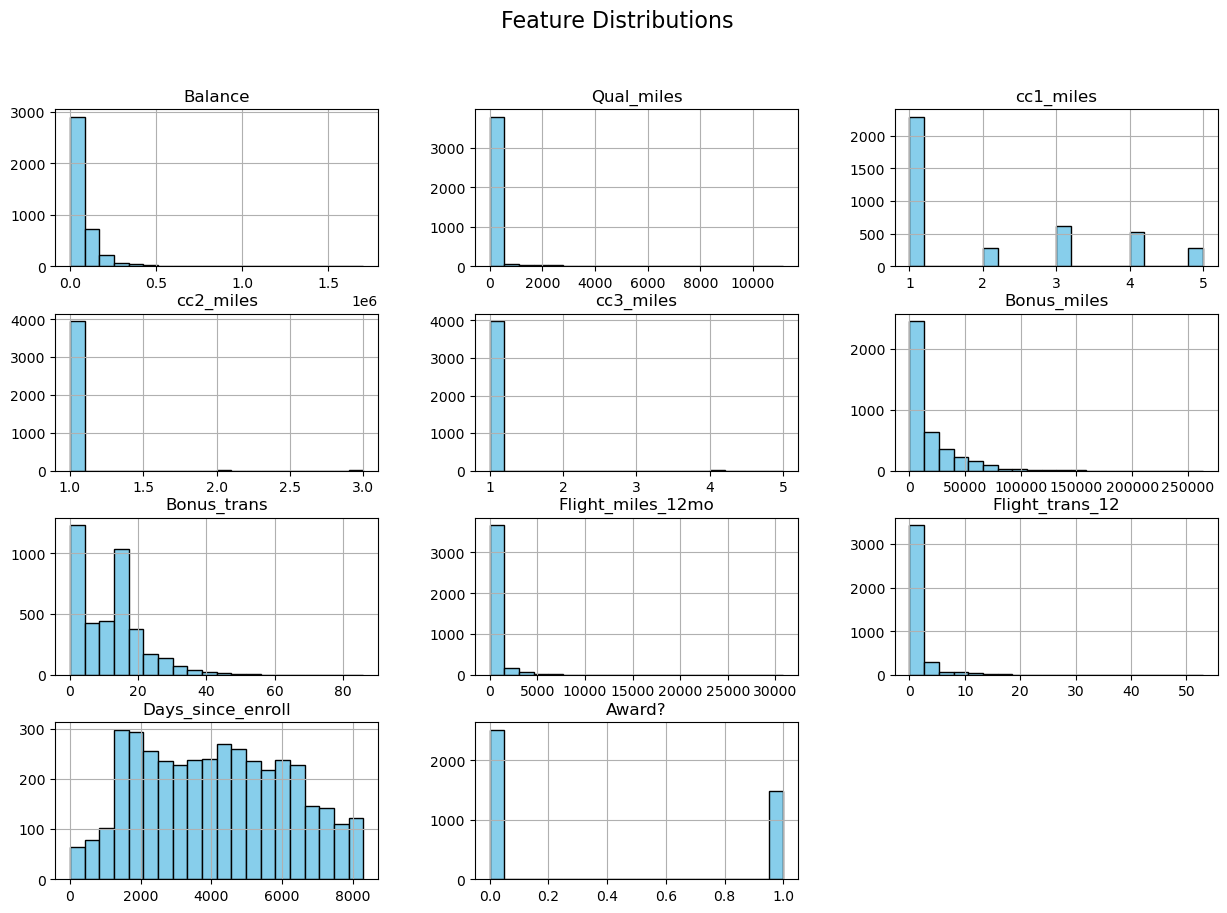

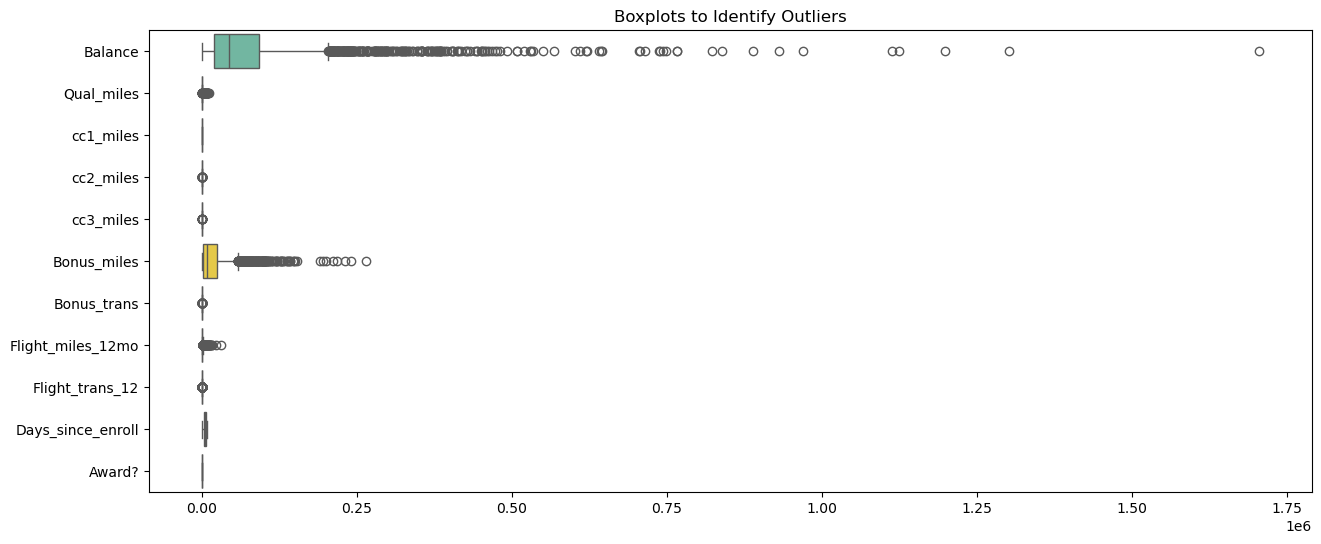

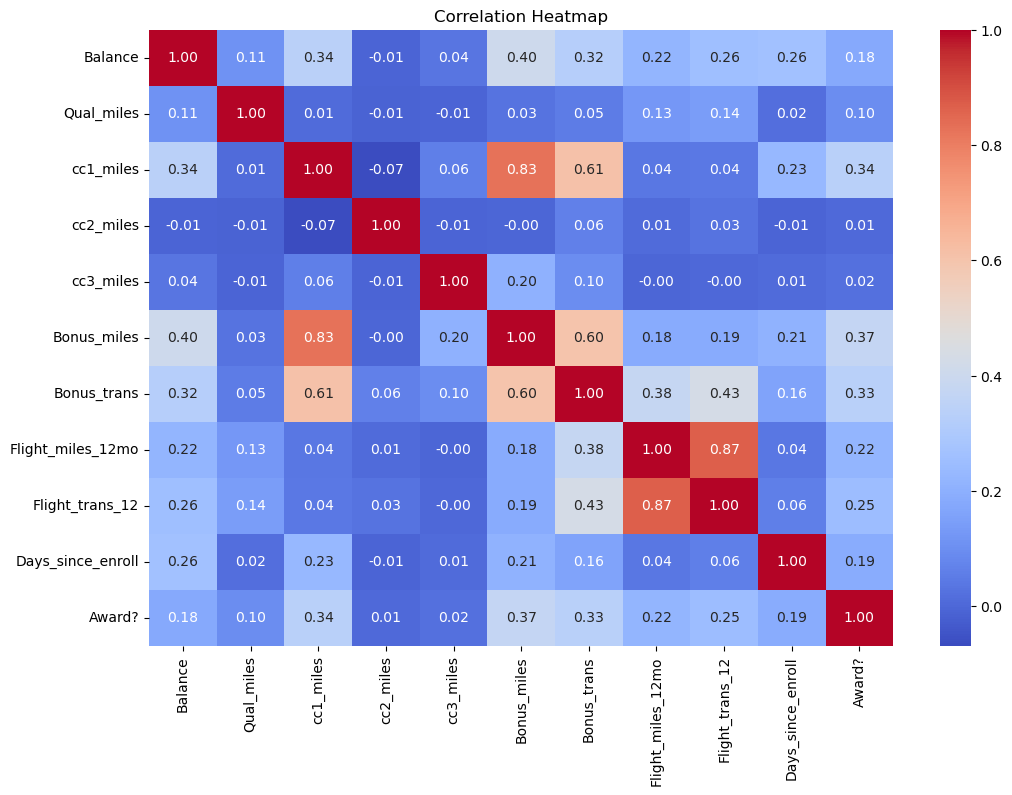

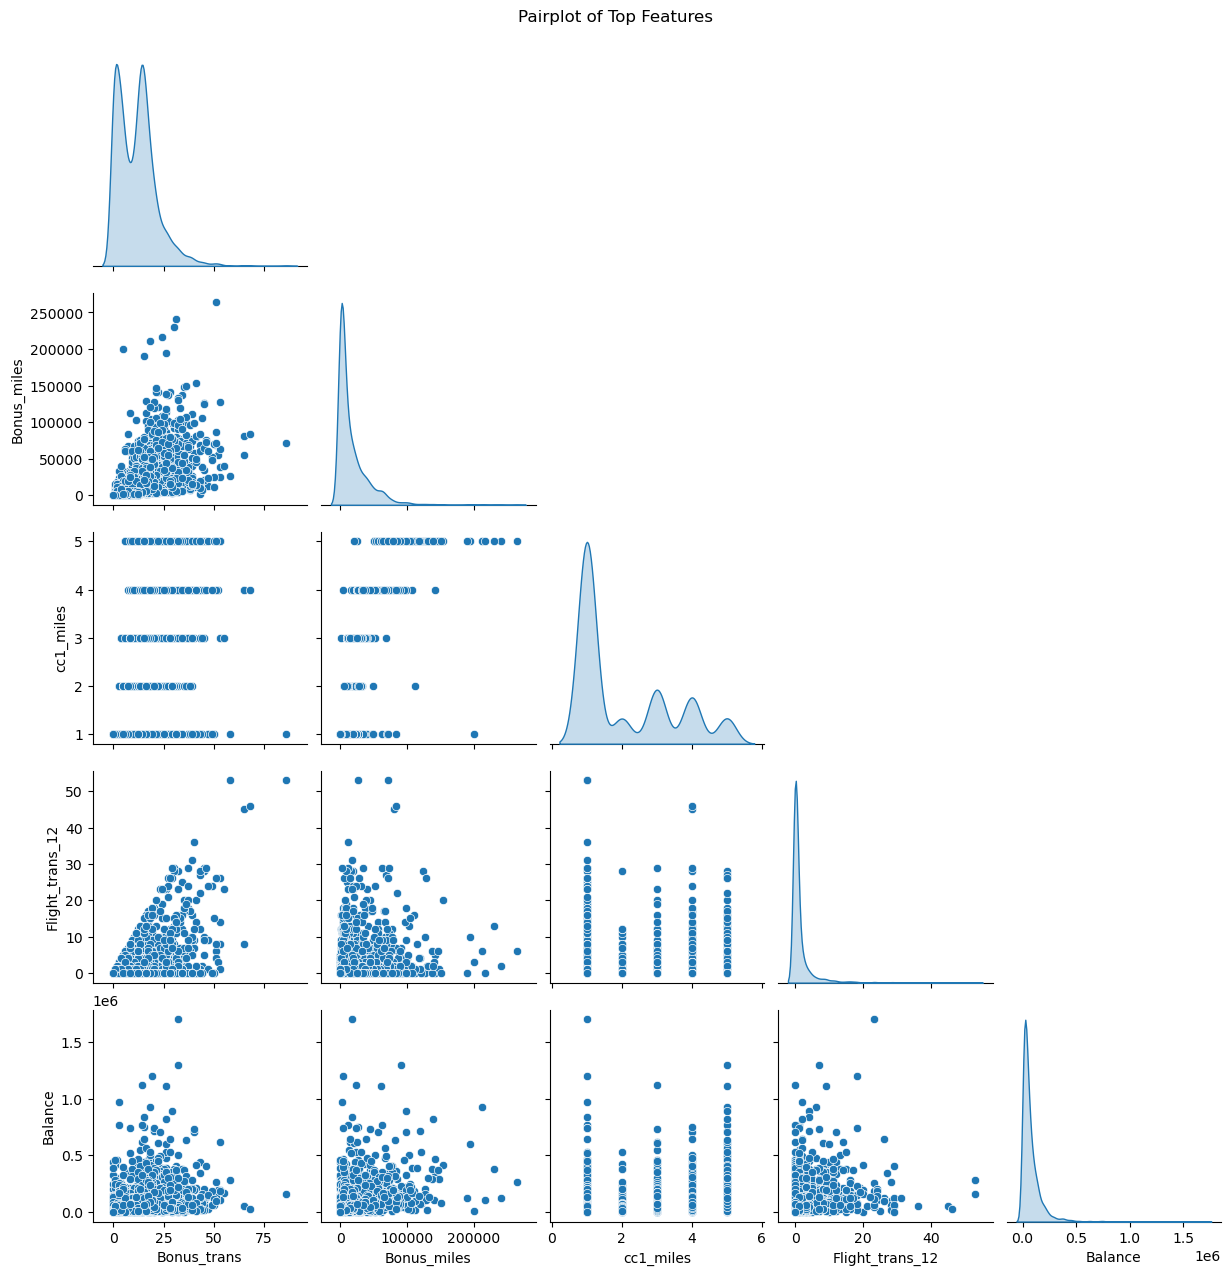

✅ Data scaled successfully.


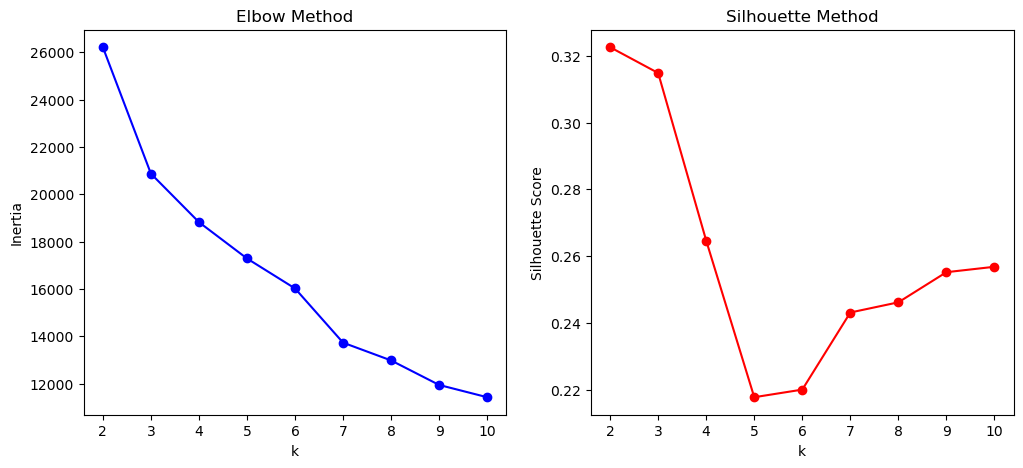


✅ Optimal number of clusters (k): 2


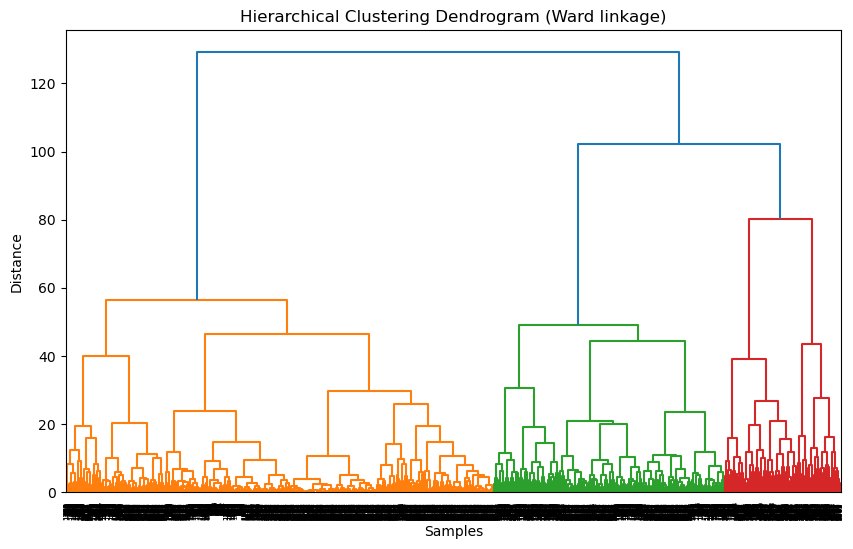


--- Silhouette Scores ---
K-Means: 0.323
Hierarchical: 0.263
DBSCAN: 0.214


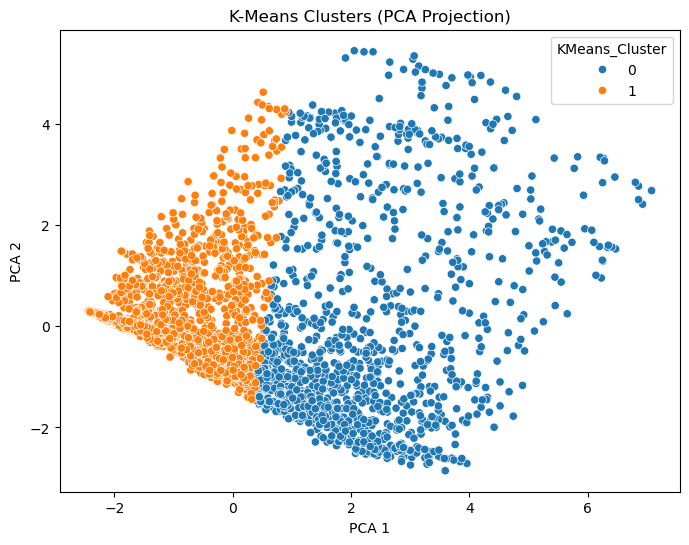

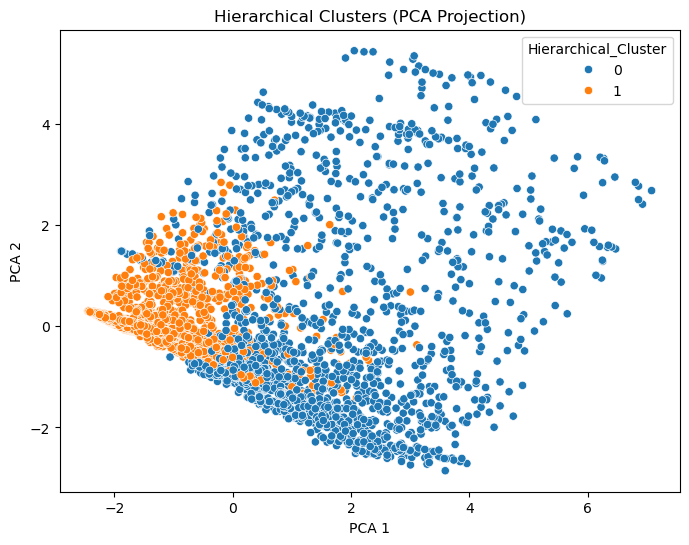

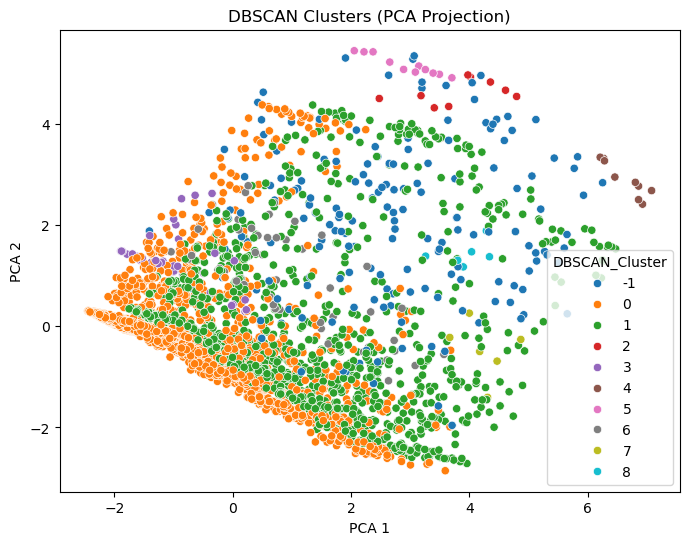


✅ Analysis complete! Results saved as 'Clustered_EastWestAirlines_with_EDA.xlsx'


In [1]:
# === EastWestAirlines Clustering Analysis with EDA ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA

# ------------------------------------------------------------------
# STEP 1: LOAD AND CLEAN DATA
# ------------------------------------------------------------------
excel_file = pd.ExcelFile("EastWestAirlines.xlsx")
print("Available sheets:", excel_file.sheet_names)

sheet_name = 'data' if 'data' in excel_file.sheet_names else excel_file.sheet_names[0]
df = pd.read_excel(excel_file, sheet_name=sheet_name)

print(f"\n✅ Loaded sheet: '{sheet_name}'")
print("Initial shape:", df.shape)
print("Columns:", list(df.columns))

# Drop ID column if present
if 'ID#' in df.columns:
    df.drop('ID#', axis=1, inplace=True)
elif 'ID' in df.columns:
    df.drop('ID', axis=1, inplace=True)

# Keep only numeric columns
df = df.select_dtypes(include=[np.number])

# Handle missing values
df = df.fillna(df.median(numeric_only=True))
print("Shape after cleaning:", df.shape)

# ------------------------------------------------------------------
# STEP 2: EXPLORATORY DATA ANALYSIS (EDA)
# ------------------------------------------------------------------
print("\n--- EDA: Basic Statistics ---")
print(df.describe())

# Distribution of all numeric variables
df.hist(bins=20, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

# Boxplots to identify outliers
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, orient='h', palette='Set2')
plt.title("Boxplots to Identify Outliers")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Pairplot for top correlated features
top_corr = df.corr().abs().mean().sort_values(ascending=False).head(5).index
sns.pairplot(df[top_corr], diag_kind='kde', corner=True)
plt.suptitle("Pairplot of Top Features", y=1.02)
plt.show()

# ------------------------------------------------------------------
# STEP 3: HANDLE OUTLIERS & SCALE FEATURES
# ------------------------------------------------------------------
# Gentle outlier clipping (5th–95th percentile)
Q1 = df.quantile(0.05)
Q3 = df.quantile(0.95)
df = df.clip(lower=Q1, upper=Q3, axis=1)

# Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
print("✅ Data scaled successfully.")

# ------------------------------------------------------------------
# STEP 4: OPTIMAL K FOR K-MEANS
# ------------------------------------------------------------------
inertia, silhouette_scores = [], []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

# Plot Elbow and Silhouette
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'ro-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()

optimal_k = K[silhouette_scores.index(max(silhouette_scores))]
print(f"\n✅ Optimal number of clusters (k): {optimal_k}")

# ------------------------------------------------------------------
# STEP 5: CLUSTERING METHODS
# ------------------------------------------------------------------
# K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(scaled_data)

# Hierarchical
Z = linkage(scaled_data, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(Z)
plt.title("Hierarchical Clustering Dendrogram (Ward linkage)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
df['Hierarchical_Cluster'] = hierarchical.fit_predict(scaled_data)

# DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=6)
df['DBSCAN_Cluster'] = dbscan.fit_predict(scaled_data)

# ------------------------------------------------------------------
# STEP 6: EVALUATION
# ------------------------------------------------------------------
def safe_silhouette(data, labels):
    unique_labels = set(labels)
    if len(unique_labels) > 1 and len(unique_labels) < len(data):
        return silhouette_score(data, labels)
    return np.nan

print("\n--- Silhouette Scores ---")
print(f"K-Means: {safe_silhouette(scaled_data, df['KMeans_Cluster']):.3f}")
print(f"Hierarchical: {safe_silhouette(scaled_data, df['Hierarchical_Cluster']):.3f}")
print(f"DBSCAN: {safe_silhouette(scaled_data, df['DBSCAN_Cluster']):.3f}")

# ------------------------------------------------------------------
# STEP 7: CLUSTER VISUALIZATION (PCA 2D)
# ------------------------------------------------------------------
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1],
                hue=df['KMeans_Cluster'], palette='tab10')
plt.title("K-Means Clusters (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1],
                hue=df['Hierarchical_Cluster'], palette='tab10')
plt.title("Hierarchical Clusters (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1],
                hue=df['DBSCAN_Cluster'], palette='tab10')
plt.title("DBSCAN Clusters (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

# ------------------------------------------------------------------
# STEP 8: SAVE RESULTS
# ------------------------------------------------------------------
df.to_excel("Clustered_EastWestAirlines_with_EDA.xlsx", index=False)
print("\n✅ Analysis complete! Results saved as 'Clustered_EastWestAirlines_with_EDA.xlsx'")



=== Cluster Evaluation Metrics ===
          Model  Silhouette  Davies-Bouldin  Calinski-Harabasz
0       K-Means       0.323           1.514           1490.119
1  Hierarchical       0.263           1.669           1205.760
2        DBSCAN       0.214           1.466            217.204


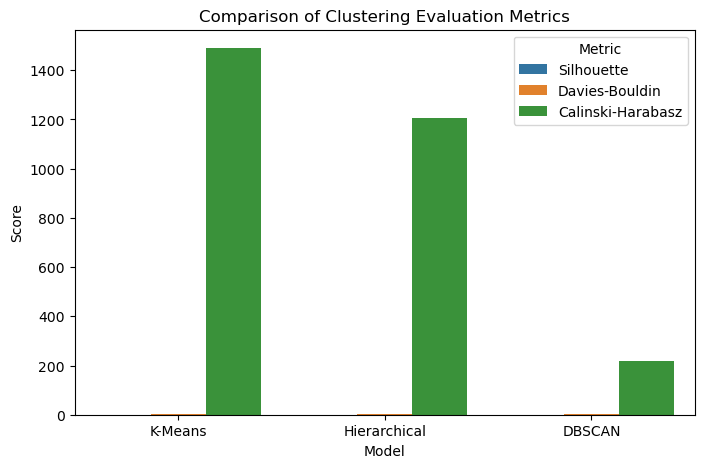

In [3]:
#STEP 6: EVALUATION & PERFORMANCE METRICS
# ------------------------------------------------------------------
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def cluster_metrics(data, labels, name):
    """Compute common internal clustering metrics."""
    unique_labels = set(labels)
    if len(unique_labels) <= 1 or len(unique_labels) == len(data):
        # invalid clustering (all points in one cluster or each in its own)
        return {
            'Model': name,
            'Silhouette': np.nan,
            'Davies-Bouldin': np.nan,
            'Calinski-Harabasz': np.nan
        }

    return {
        'Model': name,
        'Silhouette': silhouette_score(data, labels),
        'Davies-Bouldin': davies_bouldin_score(data, labels),
        'Calinski-Harabasz': calinski_harabasz_score(data, labels)
    }

# Calculate metrics for each algorithm
metrics_results = []
metrics_results.append(cluster_metrics(scaled_data, df['KMeans_Cluster'], 'K-Means'))
metrics_results.append(cluster_metrics(scaled_data, df['Hierarchical_Cluster'], 'Hierarchical'))
metrics_results.append(cluster_metrics(scaled_data, df['DBSCAN_Cluster'], 'DBSCAN'))

# Create summary DataFrame
metrics_df = pd.DataFrame(metrics_results)

print("\n=== Cluster Evaluation Metrics ===")
print(metrics_df.round(3))

# Visual comparison
plt.figure(figsize=(8,5))
sns.barplot(data=metrics_df.melt(id_vars=['Model'], var_name='Metric', value_name='Score'),
            x='Model', y='Score', hue='Metric')
plt.title("Comparison of Clustering Evaluation Metrics")
plt.ylabel("Score")
plt.show()
